In [2]:
import os
import sys

sys.path.append(os.path.join('/home/hassaku/ambiguous-segmentation/scripts/'))

import cloudpickle
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm

from modules.model import DeepImageMatting
from utils.data import get_dataloader

In [3]:
test_dir = '../data/person_image_dataset/96x64/check_20/'
bg_dir = '../data/MSCOCO/test2017_mini/'
dataloader = get_dataloader(test_dir, bg_dir, batch_size=20, data_num=20)
dataloader.shuffle = False
for pile, fg, bg, alpha, trimap in dataloader:
    pile = pile.cuda()
    fg = fg.cuda()
    bg = bg.cuda()
    alpha = alpha.cuda()

  0%|          | 0/20 [00:00<?, ?it/s]

Portrait loaded.


100%|██████████| 20/20 [00:00<00:00, 103.25it/s]
20it [00:00, 3950.55it/s]


BG loaded.
Finish piling.


In [4]:
matting_stage = DeepImageMatting(stage=1)
matting_stage.load_state_dict(torch.load('../models/stage1_sad_54.4.pth')['state_dict'], strict=True)
matting_stage.eval()

DeepImageMatting(
  (conv1_1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_3): Con

In [5]:
upsample = nn.UpsamplingBilinear2d(scale_factor=4).cuda()
maxpool = nn.MaxPool2d(4).cuda()

In [49]:
def trimap_filter(pred_alpha, pred_trimap):
    pred_alpha = pred_alpha.cuda()
    tmp = torch.where(pred_trimap < 0.33, torch.Tensor([0.]).cuda(), pred_alpha)
    tmp = torch.where(pred_trimap > 0.66, torch.Tensor([1.]).cuda(), tmp)
    return tmp

In [7]:
def visualize(img_list):
    fig = plt.figure(figsize=(20, 5), dpi=100)
    for i, imgs in enumerate(img_list):
        sample = imgs[1].cpu().detach().numpy()
        if len(sample.shape) == 2:
            pass
        elif sample.shape[0] == 1 and sample.shape[1] == 320:
            sample = sample.reshape([320, 320])
        elif sample.shape[0] == 1 and sample.shape[1] == 80:
            sample = sample.reshape([80, 80])
        else:
            sample = sample.transpose((1, 2, 0))
        sub = fig.add_subplot(1, 6, i+1)
        sub.imshow(sample, cmap="gray")

In [80]:
def visualize_row(img_list):
    for i, imgs in enumerate(img_list):
        sample = imgs.cpu().detach().numpy()
        if len(sample.shape) == 2:
            pass
        elif sample.shape[0] == 1 and sample.shape[1] == 320:
            sample = sample.reshape([320, 320, 1])
        elif sample.shape[0] == 1 and sample.shape[1] == 80:
            sample = sample.reshape([80, 80, 1])
        else:
            sample = sample.transpose((1, 2, 0))
    
        if i == 0:
            samples = sample
        else:
            samples = np.hstack((samples, sample))
            
    if samples.shape[2] == 1:
        samples = samples.reshape((samples.shape[0], samples.shape[1]))

    plt.figure(figsize=(20, 5), dpi=200)
    plt.imshow(samples, cmap="gray")

## for trimap

In [64]:
with open('/home/hassaku/ambiguous-segmentation/archives/2019-10-11_13:17/trimap_0050.model', 'rb') as f:
    trimap_stage = cloudpickle.load(f)

In [26]:
t_pred_trimap = trimap_stage(pile)
t_gray_trimap = (t_pred_trimap.max(dim=1).indices.type(torch.FloatTensor) * 0.5).view((-1, 1, 80, 80))
concat = torch.cat((pile.cpu(), t_gray_trimap), dim=1)
t_pred_alpha, _ = matting_stage(upsample(concat))
t_filtered_alpha = trimap_filter(maxpool(t_pred_alpha), t_gray_trimap.cuda())

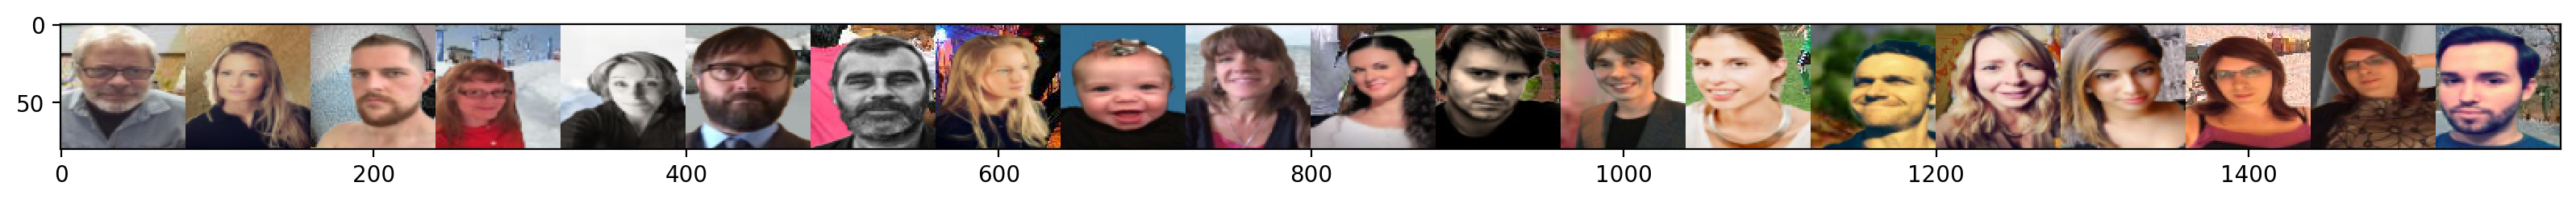

In [67]:
visualize_row(pile)

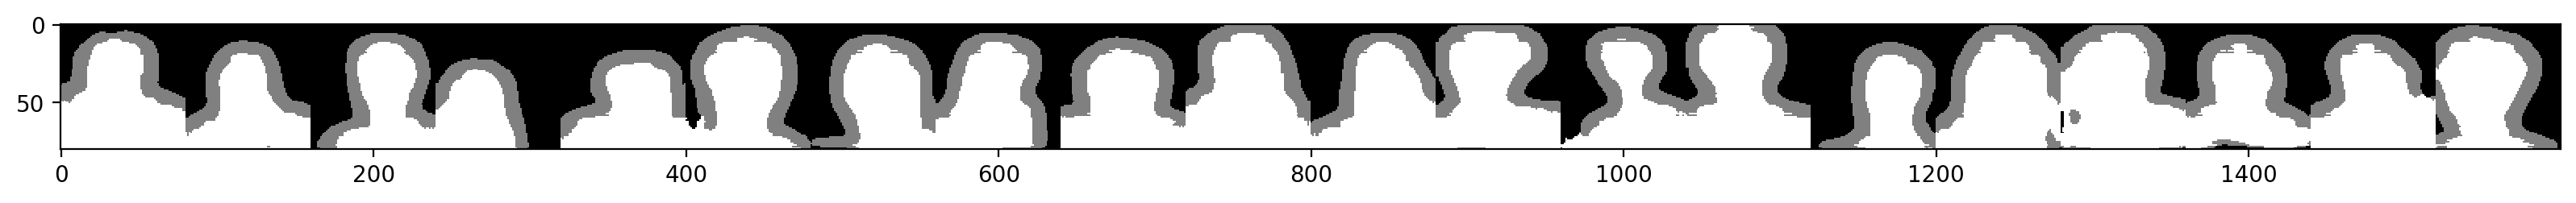

In [81]:
visualize_row(t_gray_trimap)

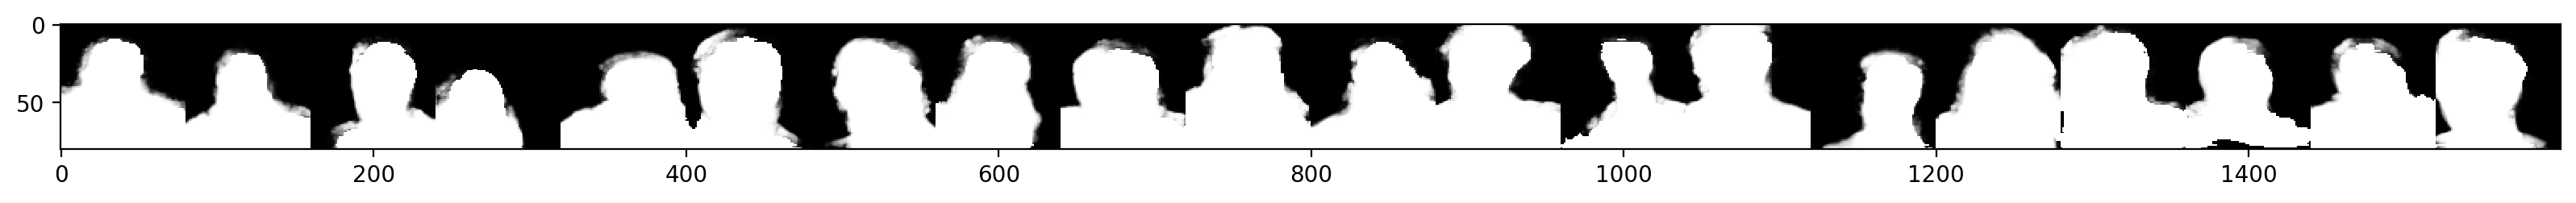

In [82]:
visualize_row(t_filtered_alpha)

## for conbined

In [91]:
with open('/home/hassaku/ambiguous-segmentation/archives/2019-10-10_00:13/trimap_0150.model', 'rb') as f:
    trimap_stage = cloudpickle.load(f)

In [92]:
trimap_stage.dropout = nn.Dropout2d(0.3)
trimap_stage.mode = 'joint'

c_gray_trimap = trimap_stage(pile)
c_concat = torch.cat((pile, c_gray_trimap), dim=1)
c_pred_alpha_big, _ = matting_stage(upsample(concat))

c_refined_trimap = c_pred_trimap.where(c_pred_trimap <= 0.33, torch.Tensor([0.5]).cuda())
c_refined_trimap = c_refined_trimap.where(c_pred_trimap <= 0.66, torch.Tensor([1.]).cuda())
c_refined_trimap = c_refined_trimap.where(c_pred_trimap >= 0.33, torch.Tensor([0.]).cuda())

c_filtered_alpha = trimap_filter(maxpool(c_pred_alpha_big), c_refined_trimap.cuda())

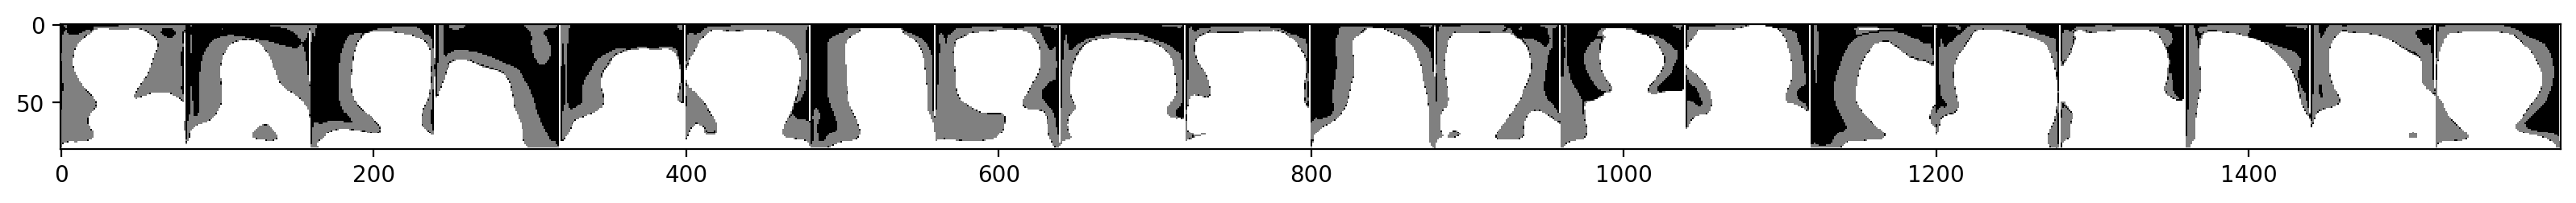

In [93]:
visualize_row(c_refined_trimap)

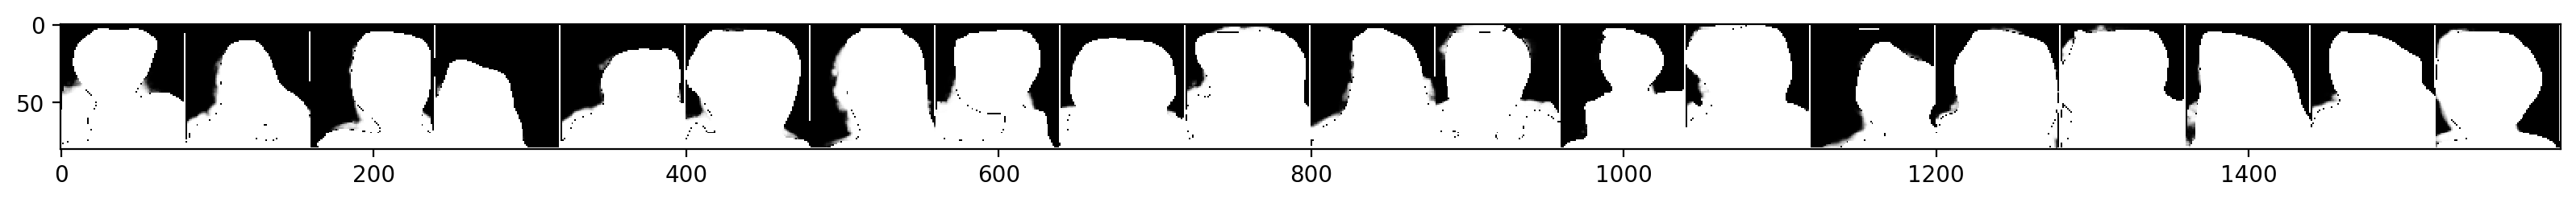

In [94]:
visualize_row(c_filtered_alpha)

## test for deep image matting

In [ ]:
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor()
])
sample_photo = transform(Image.open('/home/hassaku/ambiguous-segmentation/data/person_image_dataset/96x64/check/origin/00000.jpg'))
sample_trimap = transform(Image.open('/home/hassaku/ambiguous-segmentation/data/person_image_dataset/96x64/check/trimap/00000.jpg').convert('L'))
sample_concat = torch.cat((sample_photo, sample_trimap), dim=0).view(1, 4, 320, 320)

In [ ]:
matting_stage = DeepImageMatting()
pred_alpha_big, _ = matting_stage(concat)

In [ ]:
mse = torch.nn.functional.mse_loss

In [ ]:
sample_photo1 = transform(Image.open('/home/hassaku/ambiguous-segmentation/data/person_image_dataset/96x64/check/origin/00000.jpg'))
sample_photo2 = transform(Image.open('/home/hassaku/ambiguous-segmentation/data/person_image_dataset/96x64/check/origin/00192.jpg'))

In [ ]:
mse(sample_photo1, sample_photo2)

In [ ]:
torch.Tensor(
    np.mod(np.arange(16 * 3 * 80 * 80), 3).reshape((16, 80, 80, 3)).transpose(0, 3, 1, 2)
)

## test for segnet

In [ ]:
test_dir = '../data/person_image_dataset/96x64_one/test/'
bg_dir = '../data/MSCOCO/test2017_mini/'
dataloader = get_dataloader(test_dir, bg_dir, batch_size=1, data_num=1)
# segnet = SegNet().cuda()
with open('/home/hassaku/ambiguous-segmentation/outputs/2019-10-09_16:16/trimap_0015.model', 'rb') as f:
    segnet = cloudpickle.load(f)
mse = nn.MSELoss()
optimizer = torch.optim.Adam(segnet.parameters())

In [ ]:
transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor()
])
trimap_path = '/home/hassaku/ambiguous-segmentation/data/person_image_dataset/96x64_one/train/trimap/00000.jpg'
trimap = transform(Image.open(trimap_path).convert('L')).view(1, 1, 80, 80).cuda()

In [ ]:
for pile, fg, bg, alpha in dataloader:
    pred_trimap = segnet(pile.cuda())
plt.imshow(pred_trimap.cpu().detach().numpy().reshape(80, 80), cmap='gray')

In [ ]:
for i in tqdm(range(5000)):
    for pile, fg, bg, alpha in dataloader:
        pred_trimap = segnet(pile.cuda())
        loss = mse(pred_trimap, trimap)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            print('{} loss: {}'.format(i, loss.item()))

In [ ]:
plt.imshow(pred_trimap.cpu().detach().numpy().reshape(80, 80), cmap='gray')

## see pile

In [ ]:
with open('/home/hassaku/ambiguous-segmentation/pred_pile.torch', 'rb') as f:
    pred_pile = cloudpickle.load(f)
plt.imshow(pred_pile.cpu().detach().numpy().transpose(0, 2, 3, 1).reshape(80, 80, 3))

In [ ]:
with open('/home/hassaku/ambiguous-segmentation/target_pile.torch', 'rb') as f:
    target_pile = cloudpickle.load(f)
plt.imshow(target_pile.cpu().detach().numpy().transpose(0, 2, 3, 1).reshape(80, 80, 3))

In [ ]:
with open('/home/hassaku/ambiguous-segmentation/pred_alpha.torch', 'rb') as f:
    aaa = cloudpickle.load(f)
plt.imshow(aaa.cpu().detach().numpy().transpose(0, 2, 3, 1).reshape(80, 80), cmap='gray')